In [5]:
# In this notebook we study the multitask in depth using a PINN

# General imports
import numpy as np
import torch

# DeepMoD stuff
from multitaskpinn.model.deepmod import DeepMoD
from multitaskpinn.model.func_approx import NN
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares
from multitaskpinn.model.sparse_estimators import PINN
from multitaskpinn.training import train_multitask, train_MSE, train
from multitaskpinn.training.sparsity_scheduler import Periodic
from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta

# Setting cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Making data
v = 0.1
A = 1.0
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.2)

The regression loss terms become very small (regression) and big (scaling). We can improve the behaviour (I think) by implementing a numerically stable loss. The idea is that we can do the following:

$$
e^{-s} \mathcal{L} = \exp(-s - \log(N) + \log(\mathcal{l}))
$$

with $\mathcal{L} = 1/N \cdot \mathcal{l}$. This prevents multiplication and division by small and big numbers

# V2 - numerically stable loss

In [7]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=2) # Library function
estimator = PINN(np.arange(9).tolist()) # active terms are 2 and 5
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model
sparsity_scheduler = Periodic(initial_epoch=0, periodicity=1) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True) # Defining optimizer

In [8]:
# Running model
train_multitask(model, X_train, y_train, optimizer, sparsity_scheduler, max_iterations=50000, delta=0.0)

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      50000    100.00%               0s   -2.67e+01   1.39e-03   1.11e-10   9.32e+00 

## Analysis

In [10]:
from phimal_utilities.analysis import load_tensorboard
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
df = load_tensorboard('runs/numerically_stable/')

In [12]:
df.keys()

Index(['Total loss', 'MSE 0', 'Regression 0', 'L1 0', 'coeff 0 0', 'coeff 0 1',
       'coeff 0 2', 'coeff 0 3', 'coeff 0 4', 'coeff 0 5', 'coeff 0 6',
       'coeff 0 7', 'coeff 0 8', 'unscaled_coeff 0 0', 'unscaled_coeff 0 1',
       'unscaled_coeff 0 2', 'unscaled_coeff 0 3', 'unscaled_coeff 0 4',
       'unscaled_coeff 0 5', 'unscaled_coeff 0 6', 'unscaled_coeff 0 7',
       'unscaled_coeff 0 8', 'scale_0', 'scale_1'],
      dtype='object')

(0, 1.5)

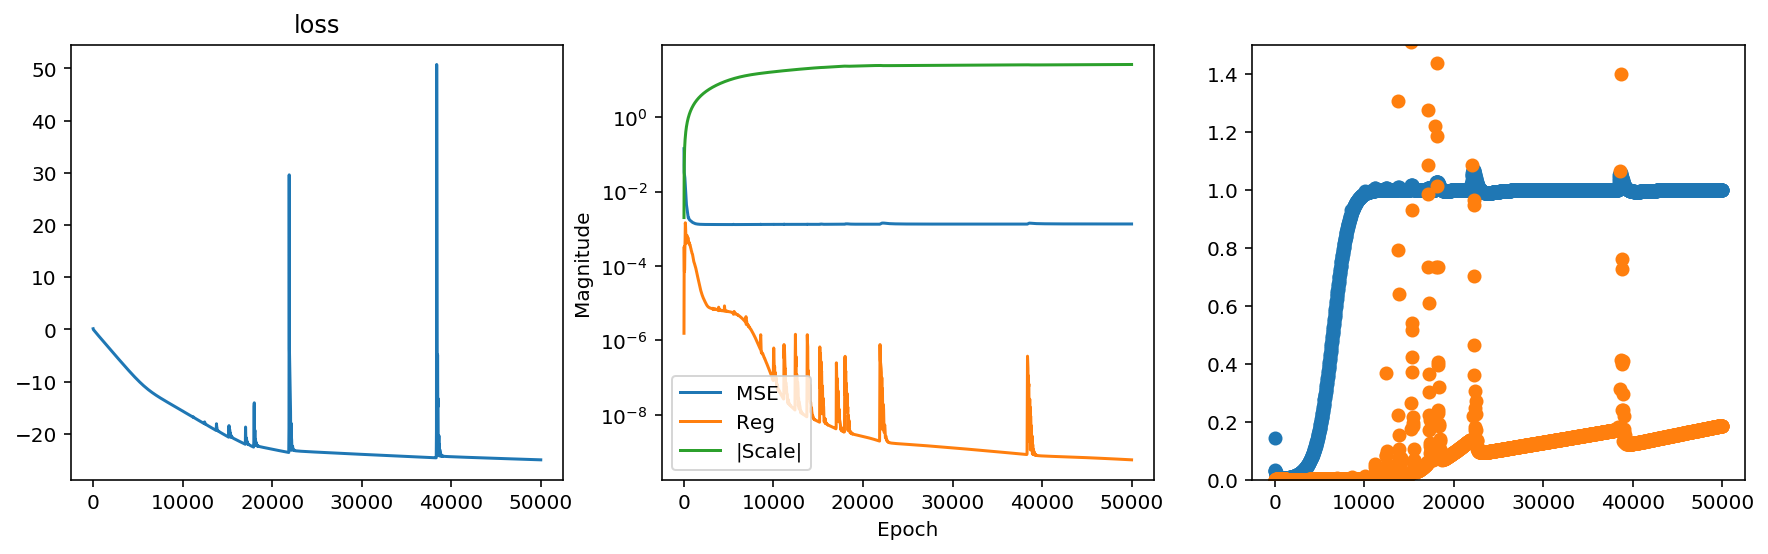

In [13]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(df.index, df['Total loss'])
plt.title('loss')

plt.subplot(132)
plt.semilogy(df.index, df['MSE 0'], label='MSE')
plt.semilogy(df.index, df['Regression 0'], label='Reg')
plt.semilogy(df.index, np.abs(df.scale_0 + df.scale_1), label='|Scale|')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Magnitude')

plt.subplot(133)
plt.plot(df.index, np.exp(-df.scale_0) * df['MSE 0'], 'o')
plt.plot(df.index, np.exp(-df.scale_1) * df['Regression 0'], 'o')
plt.ylim([0, 1.5])

Text(0.5, 1.0, 'Reg / MSE')

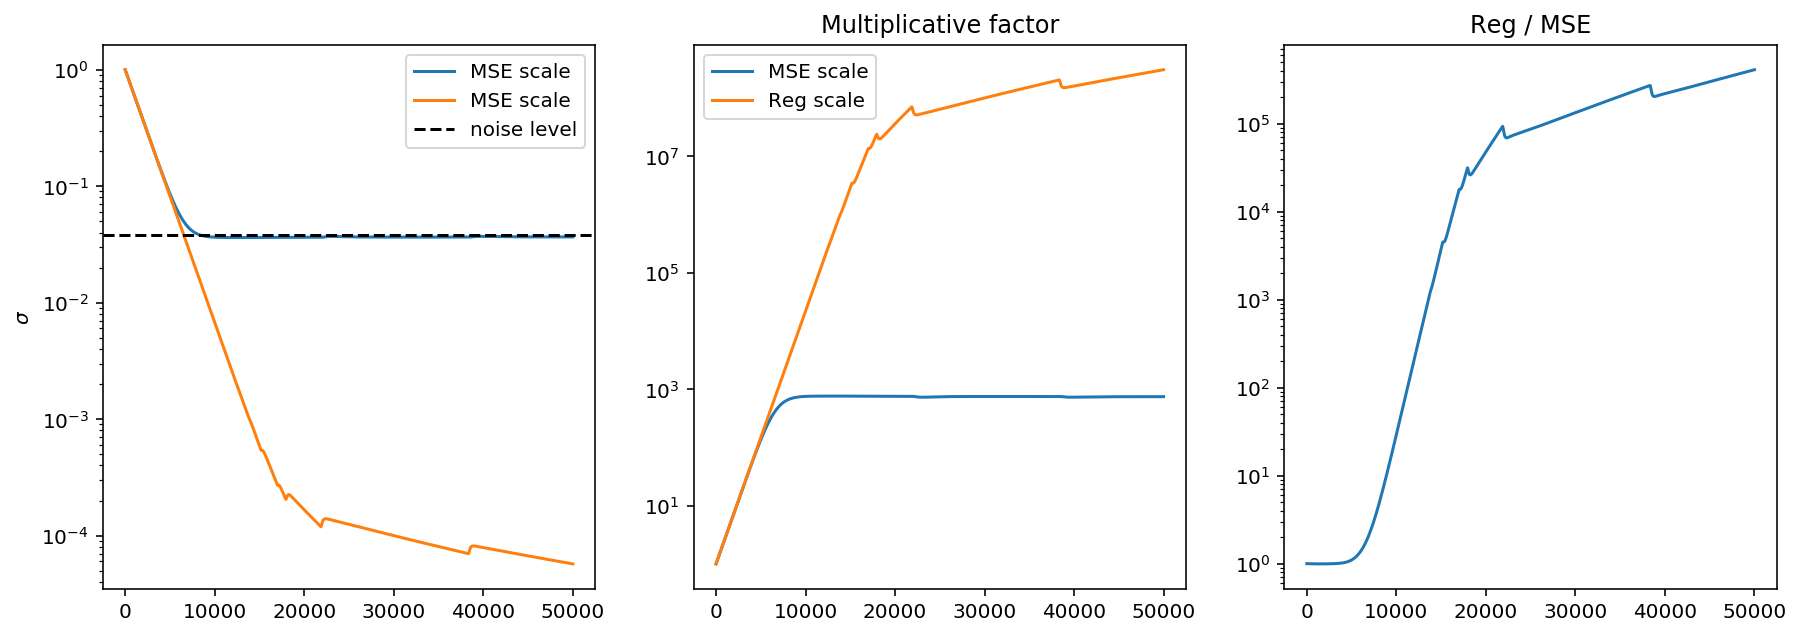

In [14]:
theoretical_noise = (0.2 * torch.std(dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.0)[1])).detach().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.semilogy(df.index, np.sqrt(np.exp(df.scale_0)), label='MSE scale')
plt.semilogy(df.index, np.sqrt(np.exp(df.scale_1)), label='MSE scale')
plt.axhline(theoretical_noise, color='k', linestyle='--', label='noise level')
plt.ylabel(r'$\sigma$')
plt.legend()

plt.subplot(132)
plt.semilogy(df.index, np.exp(-df.scale_0), label='MSE scale')
plt.semilogy(df.index, np.exp(-df.scale_1), label='Reg scale')
plt.legend()
plt.title('Multiplicative factor')

plt.subplot(133)
plt.semilogy(df.index, np.exp(-df.scale_1) / np.exp(-df.scale_0))
plt.title('Reg / MSE')

In [18]:
coeff_keys = [key for key in df.keys() if key[:len('coeff')] == 'coeff']

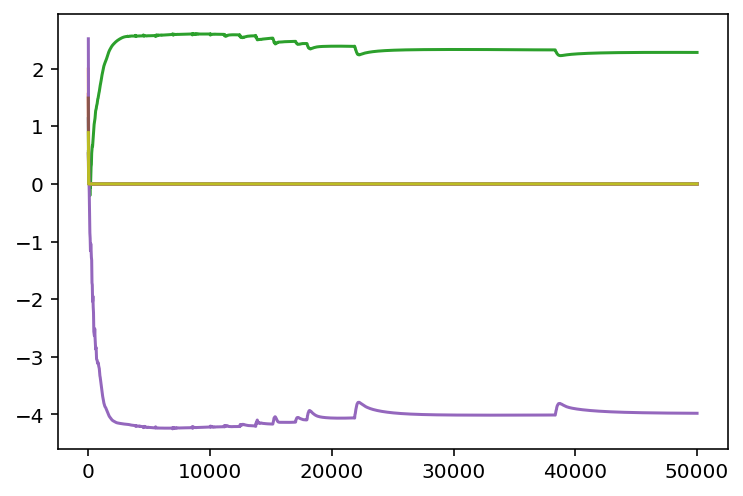

In [56]:
plt.plot(df[coeff_keys])
plt.show()

All noise levels are the same:

In [20]:
print(df.tail(1)['MSE 0'])
print(np.exp(df.tail(1)['scale_0']))
print(f'theoretical: {theoretical_noise ** 2}')

50000    0.001344
Name: MSE 0, dtype: float64
50000    0.001344
Name: scale_0, dtype: float64
theoretical: 0.001450941083021462


Regression is further off:

In [21]:
print(df.tail(1)['Regression 0'])
print(np.exp(df.tail(1)['scale_1']))
#print(f'theoretical: {theoretical_noise ** 2}')

50000    6.102100e-10
Name: Regression 0, dtype: float64
50000    3.270789e-09
Name: scale_1, dtype: float64


Let's study the regression loss in more depth as that keeps coming down:

In [22]:
prediction, time_derivs, sparse_thetas, thetas, constraint_coeffs = model(X_train)
reg = (time_derivs[0] - sparse_thetas[0] @ constraint_coeffs[0]).detach().numpy()

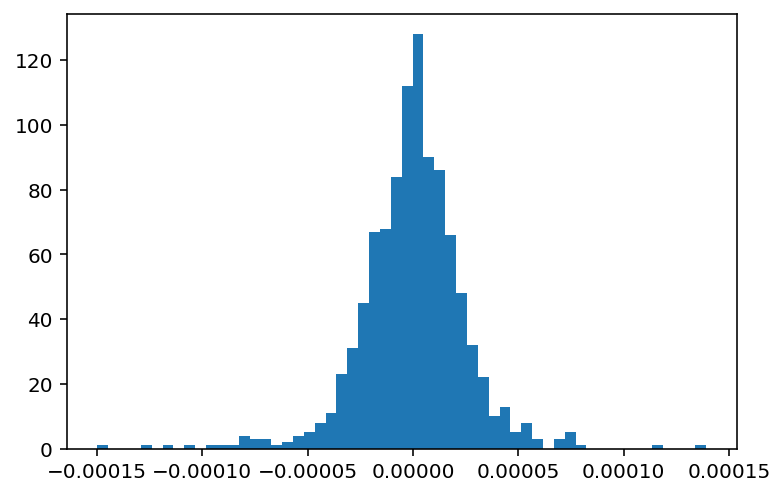

In [23]:
plt.hist(reg.squeeze(), bins='auto')
plt.show()

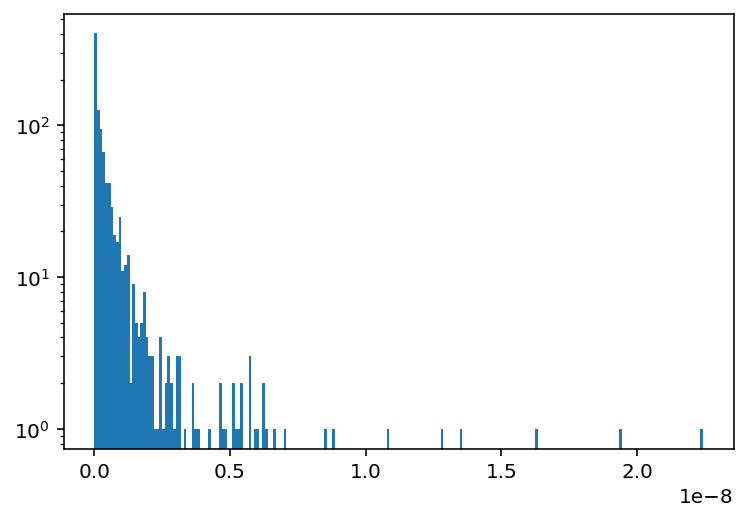

In [24]:
plt.hist(reg.squeeze()**2, bins='auto', log=True)
plt.show()

In [25]:
np.mean(reg**2)

6.102908e-10

In [26]:
np.exp(-df.tail(1)['scale_1']) * np.mean(reg**2)

50000    0.186588
Name: scale_1, dtype: float64

# Baseline

In [64]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=2) # Library function
estimator = PINN([2, 4]) # active terms are 2 and 5
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model
sparsity_scheduler = Periodic(initial_epoch=0, periodicity=1) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True) # Defining optimizer

In [65]:
# Running model
train_MSE(model, X_train, y_train, optimizer, sparsity_scheduler, max_iterations=50000, delta=0.0)

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      50000    100.00%               0s   1.30e-03   1.29e-03   7.95e-06   6.76e+00 

# Comparing

In [66]:
df_stable = load_tensorboard('runs/numerically_stable/')
df_original = load_tensorboard('runs/original/')
df_baseline = load_tensorboard('runs/MSE/')

Text(0.5, 1.0, 'Regression')

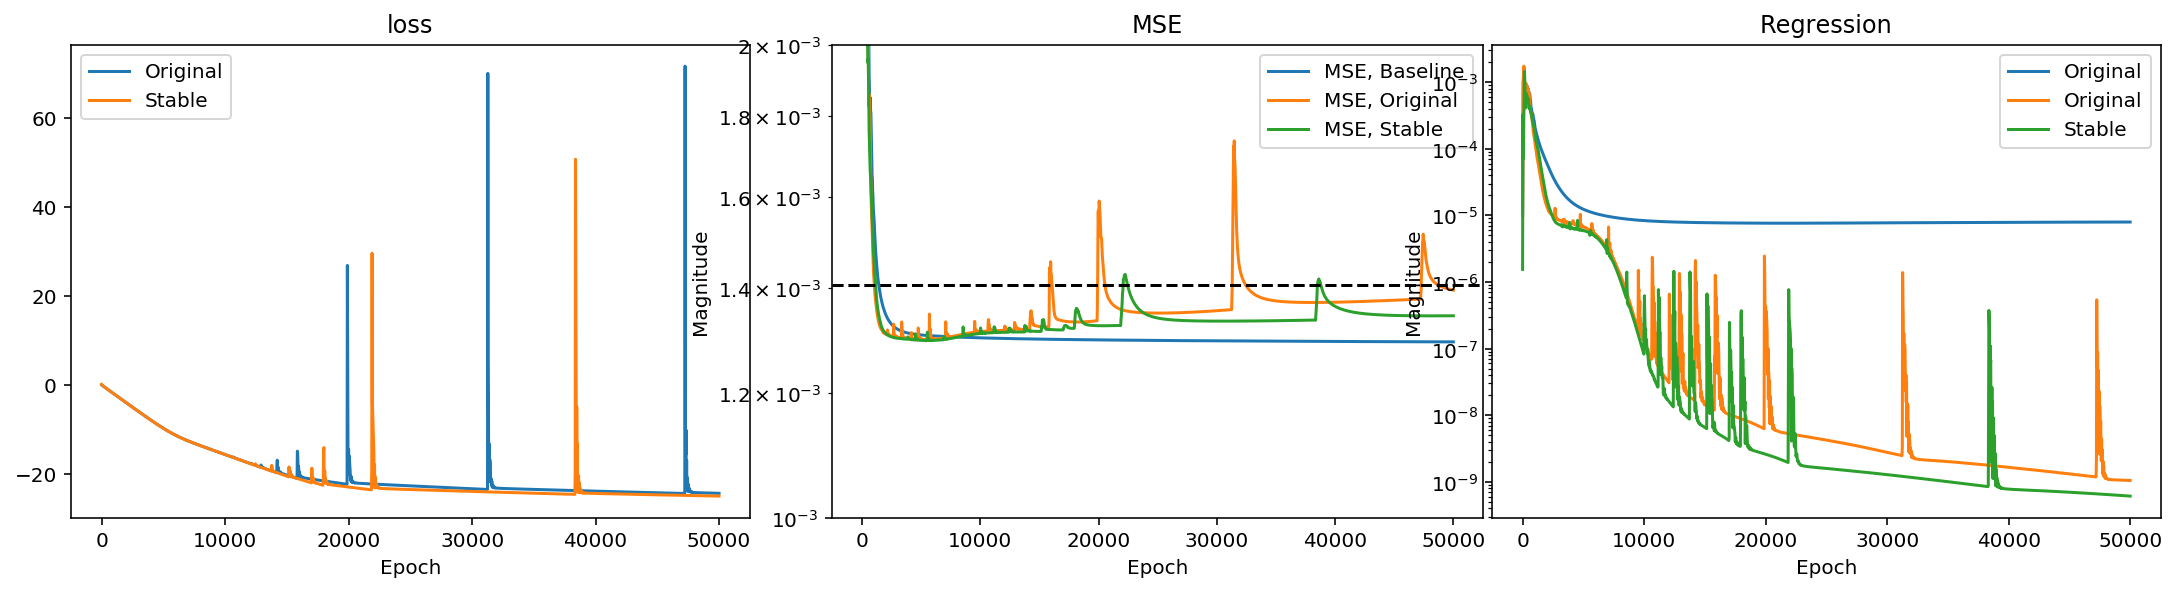

In [87]:
plt.figure(figsize=(15, 4), constrained_layout=True)
plt.subplot(131)
#plt.plot(df_original.index, df_baseline['Total loss'], label='Baseline')
plt.plot(df_original.index, df_original['Total loss'], label='Original')
plt.plot(df_stable.index, df_stable['Total loss'], label='Stable')
plt.legend()
plt.xlabel('Epoch')
plt.title('loss')

plt.subplot(132)
plt.semilogy(df_original.index, df_baseline['MSE 0'], label='MSE, Baseline')
plt.semilogy(df_original.index, df_original['MSE 0'], label='MSE, Original')
plt.semilogy(df_stable.index, df_stable['MSE 0'], label='MSE, Stable')
theoretical_noise = (0.2 * torch.std(dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.0)[1])).detach().numpy()
plt.axhline(theoretical_noise**2, color='k', linestyle='--')
plt.ylim([1e-3, 2e-3])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.title('MSE')

plt.subplot(133)
plt.semilogy(df_original.index, df_baseline['Regression 0'], label='Original')
plt.semilogy(df_original.index, df_original['Regression 0'], label='Original')
plt.semilogy(df_stable.index, df_stable['Regression 0'], label='Stable')

#plt.ylim([1e-3, 3e-3])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.title('Regression')

(0, 1.5)

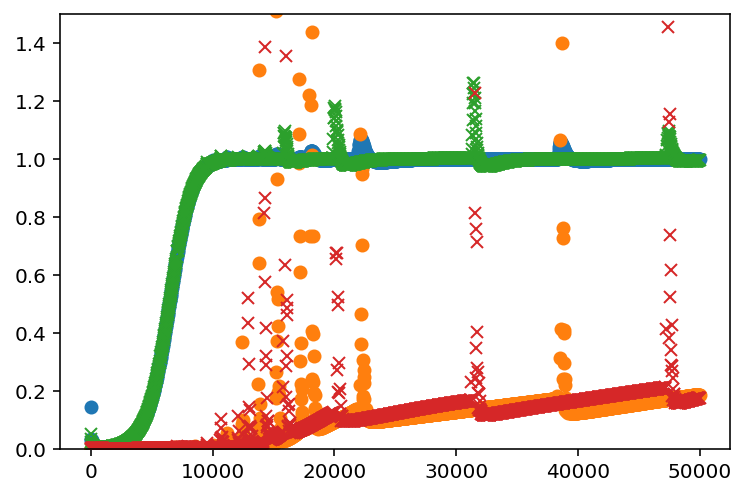

In [73]:
plt.plot(df.index, np.exp(-df_stable.scale_0) * df_stable['MSE 0'], 'o')
plt.plot(df.index, np.exp(-df_stable.scale_1) * df_stable['Regression 0'], 'o')

plt.plot(df.index, np.exp(-df_original.scale_0) * df_original['MSE 0'], 'x')
plt.plot(df.index, np.exp(-df_original.scale_1) * df_original['Regression 0'], 'x')
plt.ylim([0, 1.5])

In [77]:
coeff_keys = [key for key in df.keys() if key[:len('coeff')] == 'coeff']
real_coeff_keys = [key for key in df.keys() if key[:len('unscaled')] == 'unscaled']

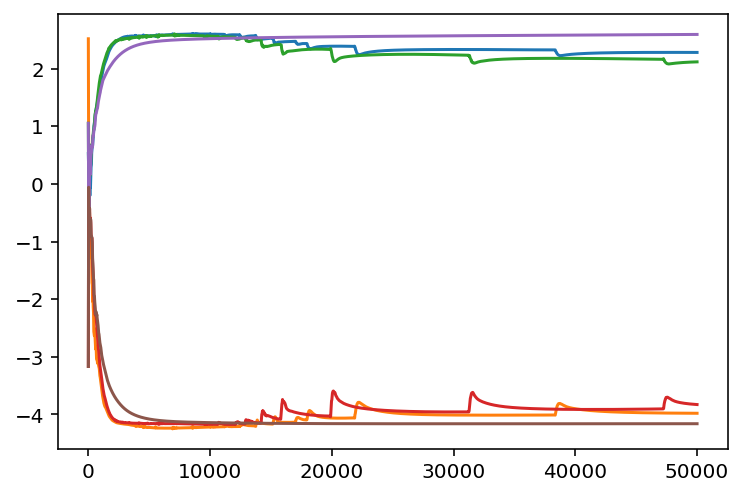

In [76]:
plt.plot(df_stable[coeff_keys[2]])
plt.plot(df_stable[coeff_keys[4]])
plt.plot(df_original[coeff_keys[2]])
plt.plot(df_original[coeff_keys[4]])

plt.plot(df_baseline[coeff_keys[2]])
plt.plot(df_baseline[coeff_keys[4]])
plt.show()

(0.0, 0.2)

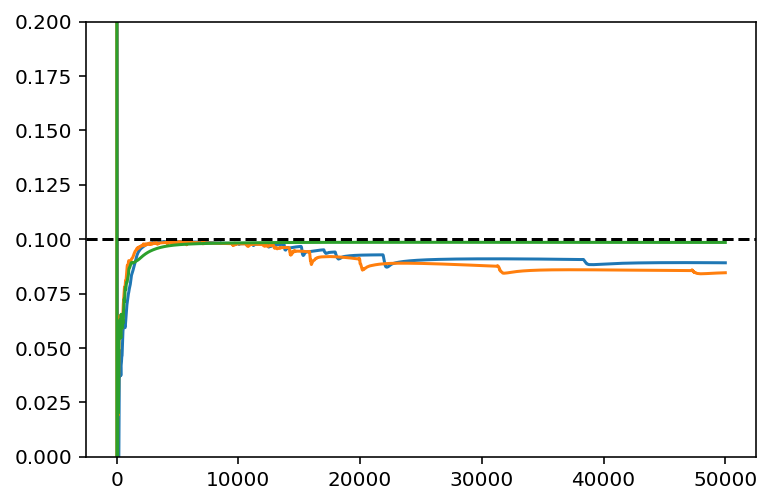

In [121]:
plt.plot(df_stable[real_coeff_keys[2]])
plt.plot(df_original[real_coeff_keys[2]])
plt.plot(df_baseline[real_coeff_keys[2]])
plt.axhline(0.1, color='k', linestyle='--')

plt.ylim([0.0, 0.2])

(-1.1, -0.9)

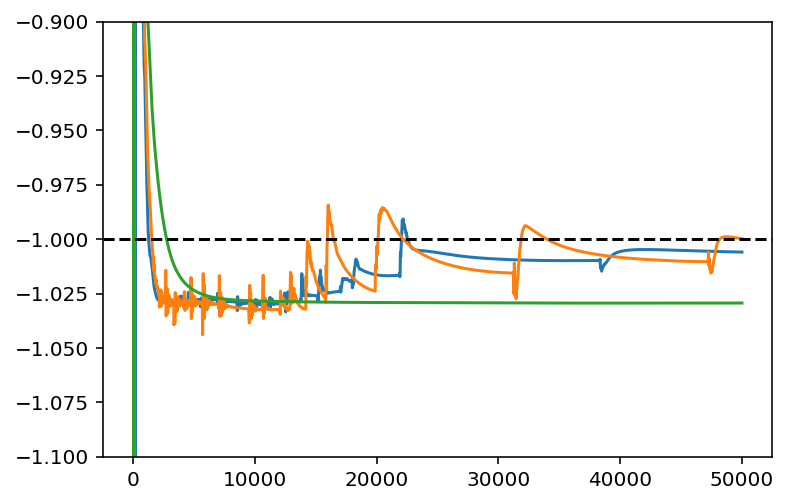

In [119]:
plt.plot(df_stable[real_coeff_keys[4]])
plt.plot(df_original[real_coeff_keys[4]])
plt.plot(df_baseline[real_coeff_keys[4]])
plt.axhline(-1.0, color='k', linestyle='--')

plt.ylim([-1.1, -0.9])

In [112]:
df_stable[real_coeff_keys[2]].tail(1)

50000    0.089129
Name: unscaled_coeff 0 2, dtype: float64

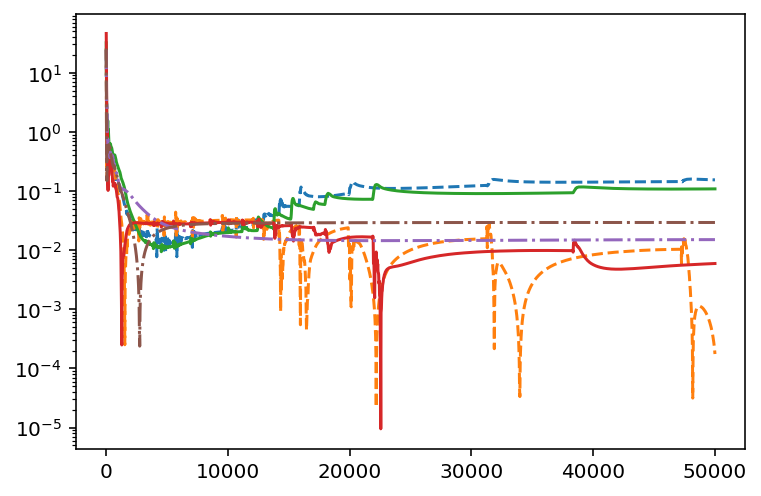

In [99]:
plt.semilogy(np.abs((df_original[real_coeff_keys[2]] - 0.1))/0.1, '--')
plt.semilogy(np.abs((df_original[real_coeff_keys[4]] + 1.0)) / 1.0, '--')

plt.semilogy(np.abs((df_stable[real_coeff_keys[2]] - 0.1))/0.1, '-')
plt.semilogy(np.abs((df_stable[real_coeff_keys[4]] + 1.0)) / 1.0, '-')

plt.semilogy(np.abs((df_baseline[real_coeff_keys[2]] - 0.1))/0.1, '-.')
plt.semilogy(np.abs((df_baseline[real_coeff_keys[4]] + 1.0)) / 1.0, '-.')

Text(0.5, 1.0, 'Relative error')

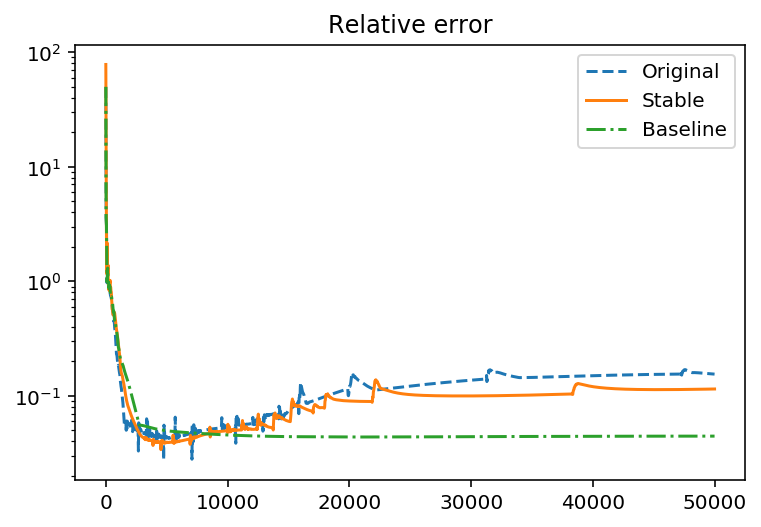

In [123]:
plt.semilogy(np.abs((df_original[real_coeff_keys[2]] - 0.1))/0.1 + np.abs((df_original[real_coeff_keys[4]] + 1.0)) / 1.0, '--', label='Original')
plt.semilogy(np.abs((df_stable[real_coeff_keys[2]] - 0.1))/0.1 + np.abs((df_stable[real_coeff_keys[4]] + 1.0)) / 1.0, '-', label='Stable')
plt.semilogy(np.abs((df_baseline[real_coeff_keys[2]] - 0.1))/0.1 + np.abs((df_baseline[real_coeff_keys[4]] + 1.0)) / 1.0, '-.', label='Baseline')
plt.legend()
plt.title('Relative error')

Text(0.5, 1.0, 'Absolute error')

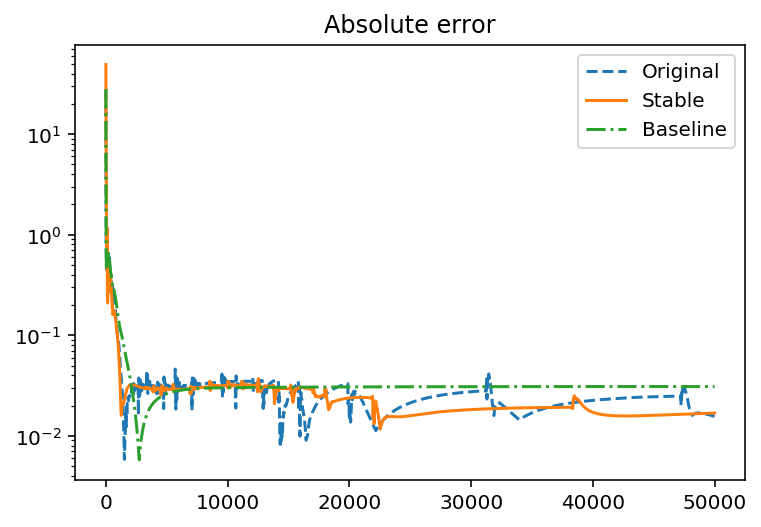

In [124]:
plt.semilogy(np.abs((df_original[real_coeff_keys[2]] - 0.1)) + np.abs((df_original[real_coeff_keys[4]] + 1.0)) , '--', label='Original')
plt.semilogy(np.abs((df_stable[real_coeff_keys[2]] - 0.1)) + np.abs((df_stable[real_coeff_keys[4]] + 1.0)) , '-', label='Stable')
plt.semilogy(np.abs((df_baseline[real_coeff_keys[2]] - 0.1)) + np.abs((df_baseline[real_coeff_keys[4]] + 1.0)), '-.', label='Baseline')
plt.legend()
plt.title('Absolute error')